# Regression model to predict protein expression in tumor and normal tissue

### Set up and functions

In [176]:
import os
import h5py
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
from math import sqrt

from mrmr import mrmr_regression, mrmr_classif
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, f1_score, average_precision_score, accuracy_score, precision_score, recall_score, confusion_matrix

In [2]:
# paths and functions
tumor_path = 'G:\My Drive\BIOINF_590\Data\Images\clam_output\\tumor\FEATURES_DIRECTORY\h5_files'
normal_path = 'G:\My Drive\BIOINF_590\Data\Images\clam_output\\normal\FEATURES_DIRECTORY\h5_files'
both_path = 'G:\My Drive\BIOINF_590\Data\Images\clam_output\\both\FEATURES_DIRECTORY\h5_files'


def make_df(path, group):
  files = os.listdir(path)
  ids = pd.DataFrame([id[:-3] for id in files], columns=['id'])
  df_ids = pd.DataFrame(ids)
  df_ids[['sample', 'id']] = df_ids['id'].str.rsplit('-', 1, expand=True)
  df_ids['file'] = df_ids['sample'] + '-' + df_ids['id'] + '.h5'
  df_ids['group'] = group

  return df_ids


def read_features(path, file_name, class_labels):
  f = h5py.File(f'{path}/{file_name}')
  x = np.array(f['features'])

  coords = np.array(f['coords'])
  x = np.hstack((np.full((x.shape[0], len(class_labels)), class_labels), x))
  x = np.hstack((coords, x))
  file_name_n_patches = [file_name, x.shape[0]]

  return x, file_name_n_patches


def get_X(df, targets):
  X = np.empty((0, 1024 + 2 + len(targets))) # 2 for the patch coords
  file_patch_dict = {}
  file_patch_count = []

  for index, row in df.iterrows():
    group = row['group']
    path = f'G:\My Drive\BIOINF_590\Data\Images\clam_output\\{group}\FEATURES_DIRECTORY\h5_files'
    x, file_name_n_patches = read_features(path, row['file'], list(row[targets].values))
    file_patch_dict[file_name_n_patches[0]] = [X.shape[0], X.shape[0]+file_name_n_patches[1]-1]
    file_patch_count.append(file_name_n_patches)
    X = np.vstack((X, x))

  return X, file_patch_dict, file_patch_count


def format_protein_expression(df, n_proteins):
  df = df.sort_values('p')
  proteins = df[:n_proteins]['gene'].values.tolist()
  df = df[:n_proteins].T.reset_index()
  new_header = df.iloc[0] 
  df = df[2:] # remove gene and p-value rows
  df.columns = new_header
  df = df.rename(columns={'gene' : 'idx'})
  
  return df, proteins


def get_proteins(df, proteins):
  df = df[df['gene'].isin(proteins)].T.reset_index()
  new_header = df.iloc[0]
  df = df[2:] # remove gene and p-value rows
  df.columns = new_header
  df = df.rename(columns={'gene' : 'idx'})

  return df


def get_patch_values(all_file_patch_counts, coords):
  patch_values = []
  i = 0
  for x in all_file_patch_counts:
    file_name = x[0] # get file name
    n = x[1] # get number of patches
    patch_coords = coords[i:i+n,:]
    i = i + n

    for patch in patch_coords:
      patch_values.append([file_name, patch[0], patch[1]])

  return patch_values


def write(patch_values, y_preds, target, file_name):
  df_results = pd.DataFrame(np.hstack((np.array(patch_values), y_preds)), columns=['file_name', 'x', 'y', target])
  df_results.to_csv(f'G:\My Drive\BIOINF_590\Data\PredictedPatchExpression\\final\{file_name}.csv', index=False)


def load_batch(df, targets):
  X, file_patch_dict, file_patch_count = get_X(df, targets)

  # extract patch coords
  coords = X[:,:2]
  X = np.delete(X, [0,1], axis=1)

  # extract class label
  y = X[:,:len(targets)]
  X = np.delete(X, list(range(len(targets))), axis=1)

  return X, y, coords, file_patch_dict, file_patch_count

## Load, format, preprocess data

### Prep metadata

In [33]:
# get metadata
df = pd.concat([make_df(normal_path, 'normal'), make_df(tumor_path, 'tumor'), make_df(both_path, 'both')])
df['class'] = df['group'].map({'normal' : 0, 'tumor' : 1, 'both' : 2})

# get id mapping
df_ids = pd.read_excel('G:\My Drive\BIOINF_590\Data\Metadata\mmc1.xlsx')
df_ids['Proteomics_Tumor_Normal'].unique()
df_ids['Proteomics_Tumor_Normal'] = df_ids['Proteomics_Tumor_Normal'].map({'Tumor' : 'tumor', 'Adjacent_normal' : 'normal', 'Myometrium_normal' : 'normal', 'Enriched_normal' : 'normal'})

# combine
df = pd.merge(df, 
         df_ids[['Proteomics_Participant_ID','idx', 'Proteomics_Tumor_Normal']], 
         left_on='sample', 
         right_on='Proteomics_Participant_ID')

df = df[(df['group'] == df['Proteomics_Tumor_Normal']) | ((df['group'] == 'both') & (df['Proteomics_Tumor_Normal'] == 'tumor'))]
df = df.drop(['Proteomics_Participant_ID','Proteomics_Tumor_Normal'], axis=1)

# get proteomics data
df_tumor_high = pd.read_csv('G:\\My Drive\\BIOINF_590\\Data\\ExpressionData\\ucec_proteome_tumor_high_p.txt', delimiter='\t')
df_tumor_low = pd.read_csv('G:\\My Drive\\BIOINF_590\\Data\\ExpressionData\\ucec_proteome_tumor_low_p.txt', delimiter='\t')


# get significantly upregulated proteins
df_tumor_high_sig = df_tumor_high[df_tumor_high['p'] < (0.05 / 9799)].sort_values('p')
df_tumor_high_sig = df_tumor_high_sig.T.reset_index()
new_header = df_tumor_high_sig.iloc[0] 
df_tumor_high_sig = df_tumor_high_sig[2:] # remove gene and p-value rows
df_tumor_high_sig.columns = new_header
df_tumor_high_sig = df_tumor_high_sig.rename(columns={'gene' : 'idx'})

df = pd.merge(df, df_tumor_high_sig, on='idx')

# make balanced subset (without data leakage) for training and testing 
df2 = df[df['group'] != 'both'].groupby('sample').first().reset_index()

### Prep feature and target data for models

[Text(0.5, 1.0, 'CTNNB1 Expression in 60 tumor samples')]

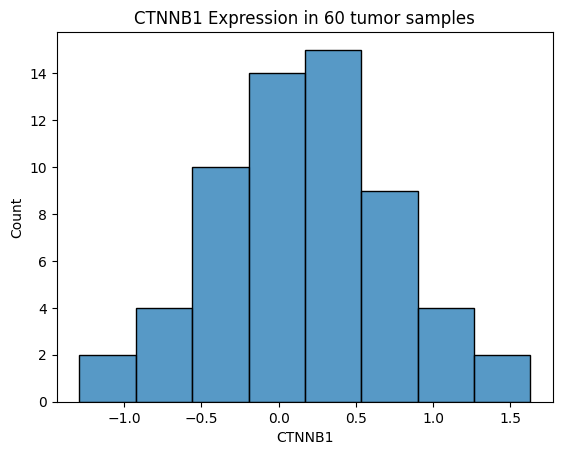

In [188]:
df_tumor = df[df['group'] == 'tumor'].groupby('sample').first()
sns.histplot(data=df_tumor, x='CTNNB1').set(title='CTNNB1 Expression in 60 tumor samples')

#### Predict preotein expression in tumor only

In [183]:
df_tumor = df[df['group'] == 'tumor'].groupby('sample').first()

# get data and split it
df_train, df_test = train_test_split(df_tumor, test_size=0.3, random_state=0)
X_train, y_train, coords_train, file_patch_dict_train, file_patch_count_train = load_batch(df_train, ['CTNNB1'])
X_test, y_test, coords_test, file_patch_dict_test, file_patch_count_test = load_batch(df_test, ['CTNNB1'])


# feature selection
feature_idx = mrmr_regression(X=pd.DataFrame(X_train), y=pd.DataFrame(y_train), K=100, show_progress=True)
X_train = X_train[:,feature_idx]
X_test = X_test[:,feature_idx]


# Random forest
rf = RandomForestRegressor(n_estimators=300, max_depth=10, min_samples_leaf=1000, min_samples_split=2000, max_features=10).fit(X_train, y_train)

y_preds = rf.predict(X_train)
print(mean_absolute_error(y_train, y_preds), r2_score(y_train, y_preds))

y_preds = rf.predict(X_test)
print(mean_absolute_error(y_test, y_preds), r2_score(y_test, y_preds))

100%|██████████| 100/100 [06:37<00:00,  3.98s/it]


0.3782303079422127 0.4030669569130365
0.48114817284964034 -0.03917952675844538


In [184]:
# standardize the features
scaler = StandardScaler()
scaler.fit(X_train)
X_train2 = scaler.transform(X_train)
X_test2 = scaler.transform(X_test)

# linear regression
lr = LinearRegression().fit(X_train2, y_train)

y_preds = lr.predict(X_train2)
print(mean_absolute_error(y_train, y_preds), r2_score(y_train, y_preds))

y_preds = lr.predict(X_test2)
print(mean_absolute_error(y_test, y_preds), r2_score(y_test, y_preds))

0.23119374986268218 0.5576048472956104
0.5839869721922455 0.12806810614321662


In [185]:
# predict binned expression
df_tumor = df[df['group'] == 'tumor'].groupby('sample').first()
df_tumor['CTNNB1_bin'] = pd.cut(df_tumor['CTNNB1'], bins=3, labels=list(range(3)))

# get data and split it
df_train, df_test = train_test_split(df_tumor, test_size=0.3, random_state=0)
X_train, y_train, coords_train, file_patch_dict_train, file_patch_count_train = load_batch(df_train, ['CTNNB1_bin'])
X_test, y_test, coords_test, file_patch_dict_test, file_patch_count_test = load_batch(df_test, ['CTNNB1_bin'])

# feature selection
feature_idx = mrmr_classif(X=pd.DataFrame(X_train), y=pd.DataFrame(y_train), K=100, show_progress=True)
X_train = X_train[:,feature_idx]
X_test = X_test[:,feature_idx]

# Random forest
rf = RandomForestClassifier(n_estimators=300, max_depth=10, min_samples_leaf=1000, min_samples_split=2000, max_features=10).fit(X_train, y_train)

y_pred_proba = rf.predict_proba(X_train)[:,1]
y_preds = rf.predict(X_train)
print('Accuracy,', accuracy_score(y_train, y_preds))
print('Confusion Matrix:\n,', confusion_matrix(y_train, y_preds))

y_pred_proba = rf.predict_proba(X_test)[:,1]
y_preds = rf.predict(X_test)
print('Accuracy,', accuracy_score(y_test, y_preds))
print('Confusion Matrix:\n,', confusion_matrix(y_test, y_preds))

100%|██████████| 100/100 [06:05<00:00,  3.66s/it]


Accuracy, 0.8165257870012824
Accuracy, 0.4841411123666816


#### Predict in both tumor and normal tissue

In [ ]:
# get protein with largest cohen's d
foo = list()
for protein in df_tumor_high[df_tumor_high['p'] < (0.05 / 9799)].sort_values('p')['gene'].values:
    p = df_tumor_high[df_tumor_high['gene'] == protein]['p'].iloc[0]
    means = df2.groupby('group')[protein].mean()
    stds = df2.groupby('group')[protein].std()

    cohens_d = (means[0] - means[1]) / (sqrt((stds[0] ** 2 + stds[1] ** 2) / 2))

    foo.append([protein, p, cohens_d])

bar = pd.DataFrame(foo, columns=['protein', 'p', 'cohens_d'])
print(bar.sort_values('cohens_d').iloc[0])
protein = bar.sort_values('cohens_d').iloc[0]['protein']


# plot
sns.boxplot(data=df2, x='group', y=protein, color='grey')
sns.stripplot(data=df2, x='group', y=protein, color='black').set(ylabel=f'{protein} Expression', title=f'{protein} Differential Expression')

In [150]:
# get data and split it
df2_train, df2_test = train_test_split(df2, test_size=0.3, random_state=0, stratify=df2['class'])
X_train, y_train, coords_train, file_patch_dict_train, file_patch_count_train = load_batch(df2_train, [protein])
X_test, y_test, coords_test, file_patch_dict_test, file_patch_count_test = load_batch(df2_test, [protein])

In [151]:
# feature selection
feature_idx = mrmr_regression(X=pd.DataFrame(X_train), y=pd.DataFrame(y_train), K=100, show_progress=True)
X_train = X_train[:,feature_idx]
X_test = X_test[:,feature_idx]

100%|██████████| 100/100 [06:58<00:00,  4.19s/it]


In [154]:
# randomly downsample
def rand_downsample(X, y, frac):
    n_patches = X.shape[0]
    idx = np.random.randint(0, n_patches, round(n_patches * frac))
    return X[idx,:], y[idx,:]

X_train_sample, y_train_sample  = rand_downsample(X_train, y_train, 0.1)
X_test_sample, y_test_sample = rand_downsample(X_test, y_test, 0.1)

print(X_train_sample.shape)
print(X_test_sample.shape)

rf = RandomForestRegressor(n_estimators=100, max_depth=10, min_samples_leaf=100, min_samples_split=200, max_features=10).fit(X_train_sample, y_train_sample)

y_preds = rf.predict(X_train_sample)
print(mean_absolute_error(y_train_sample, y_preds), r2_score(y_train_sample, y_preds))

y_preds = rf.predict(X_test_sample)
print(mean_absolute_error(y_test_sample, y_preds), r2_score(y_test_sample, y_preds))

(16032, 100)
(7617, 100)
0.13174345729638634 0.7683873941758783
0.3067722023174117 0.3191980418460938


In [ ]:
# standardize the features
scaler = StandardScaler()
scaler.fit(X_train)
X_train2 = scaler.transform(X_train)
X_test2 = scaler.transform(X_test)

# train and test model
lr = LinearRegression().fit(X_train2, y_train)

y_preds = lr.predict(X_train2)
print(mean_absolute_error(y_train, y_preds), r2_score(y_train, y_preds))

y_preds = lr.predict(X_test2)
print(mean_absolute_error(y_test, y_preds), r2_score(y_test, y_preds))

#### Predict tumor vs normal

In [ ]:
# tumor vs normal classifier

# get data and split it
df2_train, df2_test = train_test_split(df2, test_size=0.3, random_state=0, stratify=df2['class'])
X_train, y_train, coords_train, file_patch_dict_train, file_patch_count_train = load_batch(df2_train, ['class'])
X_test, y_test, coords_test, file_patch_dict_test, file_patch_count_test = load_batch(df2_test, ['class'])

model = LogisticRegression().fit(X_train, y_train)

y_pred_proba = model.predict_proba(X_train)[:,1]
y_preds = model.predict(X_train)
print('AUC', roc_auc_score(y_train, y_pred_proba))
print('F1', f1_score(y_train, y_preds))
print('Confusion Matrix:\n,', confusion_matrix(y_train, y_preds))

y_pred_proba = model.predict_proba(X_test)[:,1]
y_preds = model.predict(X_test)

print('AUC', roc_auc_score(y_test, y_pred_proba))
print('AUPRC', average_precision_score(y_test, y_pred_proba))
print('F1', f1_score(y_test, y_preds))
print('Accuracy,', accuracy_score(y_test, y_preds))
print('Precision,', precision_score(y_test, y_preds))
print('Recall,', recall_score(y_test, y_preds))
print('Confusion Matrix:\n,', confusion_matrix(y_test, y_preds))

del X_train, y_train, coords_train, file_patch_dict_train, file_patch_count_train
del X_test, y_test, coords_test, file_patch_dict_test, file_patch_count_test

#### Run model on all patches

In [ ]:
# RUN MODEL ON ALL SLIDES

dfs = np.array_split(df, 30) # split data into pieces
all_y_preds = []
all_coords = []
all_file_patch_dicts = []
all_file_patch_counts = []

# iteratively fit
for d in dfs:
  X, y, coords, file_patch_dict, file_patch_count = load_batch(d, ['RTKN'])
  X = scaler.transform(X)
  y_preds = model.predict(X)

  del X, y
  all_y_preds.append(y_preds)
  all_coords.append(coords)
  all_file_patch_counts.extend(file_patch_count)

all_y_preds = np.vstack(all_y_preds)
all_coords = np.vstack(all_coords)

In [ ]:
# format and write results
patch_values = get_patch_values(all_file_patch_counts, all_coords)
write(patch_values, all_y_preds, 'RTKN', 'all_slides_RTKN')